In [1]:
from SurrogateGenerator import segm_shuffle, trajectory_plot, get_nth_colony, surrogate_aaft, get_n_aafts, get_n_segm_shuffles
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
import pandas as pd
import numpy as np
from os.path import join
from scipy.stats import rankdata
from numpy.fft import fft, ifft

In [2]:
df = get_nth_colony(0)
surrs = get_n_segm_shuffles(df, 4, 'x', 'y', 'ant_id', 10)

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [3]:
df = get_nth_colony(0)
surrs = get_n_aafts(df, 4, 'x', 'y', 'ant_id')

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surrogate_data = pd.concat([surrogate_data, temp_df], ignore_index=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surrogate_data = pd.concat([surrogate_data, temp_df], ignore_index=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:186: FutureWarning: The 

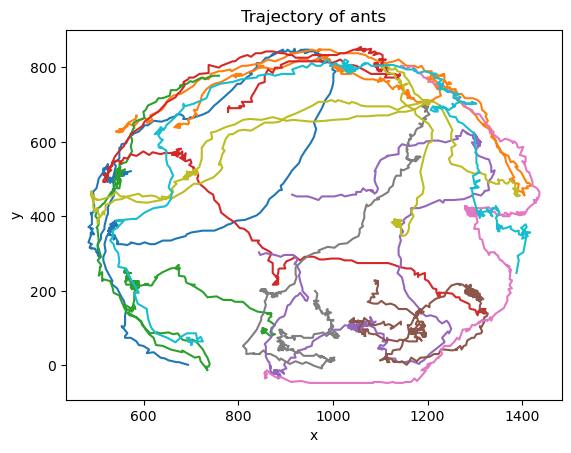

In [4]:
df = get_nth_colony(0)
trajectory_plot(df, 'x', 'y', 'ant_id')

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surrogate_data = pd.concat([surrogate_data, temp_df], ignore_index=True)


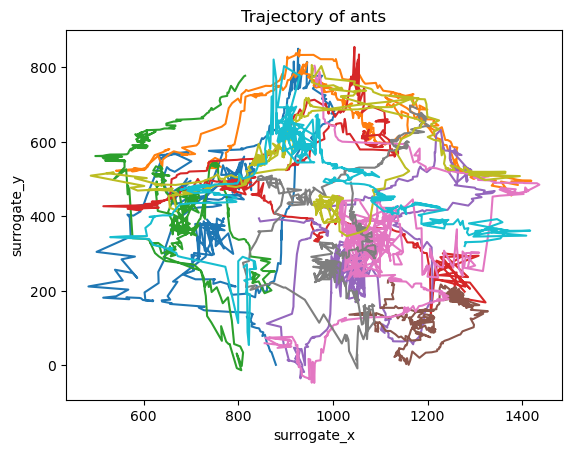

In [5]:
sa = surrogate_aaft(df, 'x', 'y', 'ant_id')
trajectory_plot(sa, 'surrogate_x', 'surrogate_y', 'ant_id')

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

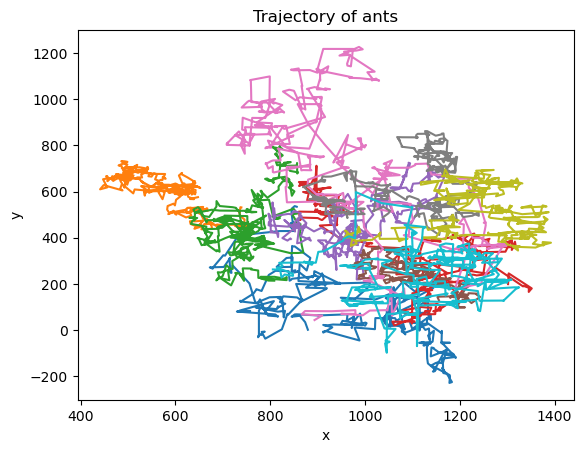

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

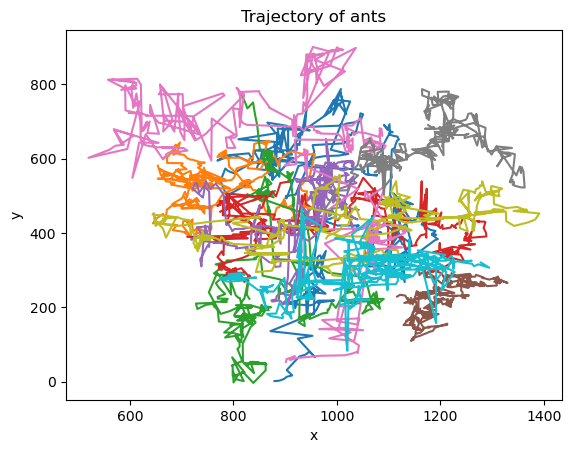

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

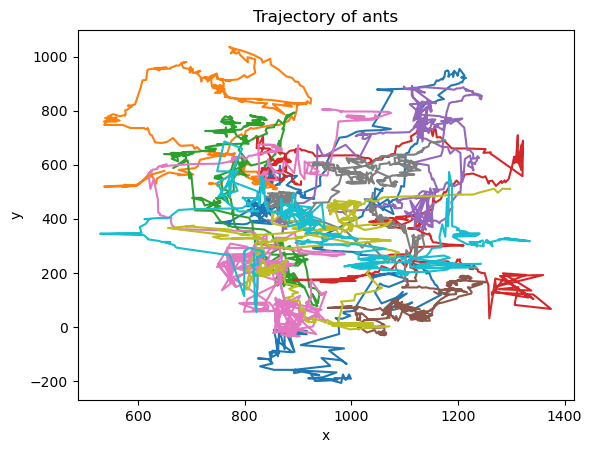

/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/home/danaconda/projects/Complex/Complex_Systems_2024/SurrogateGenerator.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

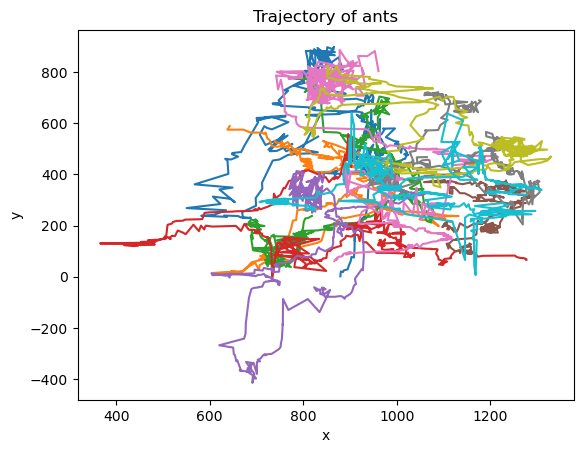

In [6]:
ss = segm_shuffle(df, 'x', 'y', 'ant_id', 1)
trajectory_plot(ss, 'x', 'y', 'ant_id')
ss = segm_shuffle(df, 'x', 'y', 'ant_id', 10)
trajectory_plot(ss, 'x', 'y', 'ant_id')
ss = segm_shuffle(df, 'x', 'y', 'ant_id', 50)
trajectory_plot(ss, 'x', 'y', 'ant_id')
ss = segm_shuffle(df, 'x', 'y', 'ant_id', 100)
trajectory_plot(ss, 'x', 'y', 'ant_id')

In [9]:
import os

# construct filepath with os join dataset ants SurrogateTrajectoriesDataset 
folderpath = os.path.join('dataset', 'ants', 'SurrogateTrajectoriesDataset')

# get files in folderpath
files = os.listdir(folderpath)

# loop through files
for file in files:
    filepath = os.path.join(folderpath, file)
    
    # the files are npy dictionaries with keys 'surrogate0', surrogate1', 'surrogate2', ..., 'surrogate19' each containing a dataframe, save the dataframes to csv
    data = np.load(filepath, allow_pickle=True)
    for key in data.keys():
        data[key].to_csv(os.path.join(folderpath, file.split('.')[0] + '_' + key + '.csv'))


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [10]:
import os
import numpy as np

# construct filepath
folderpath = os.path.join('dataset', 'ants', 'SurrogateTrajectoriesDataset')

# get files in folderpath
files = os.listdir(folderpath)

# loop through files
for file in files:
    filepath = os.path.join(folderpath, file)
    
    # load the data
    data = np.load(filepath, allow_pickle=True)
    
    # check if data is a dictionary
    if isinstance(data, dict):
        # loop through each key in the dictionary
        for key, dataframe in data.items():
            # save each dataframe to csv
            csv_path = os.path.join(folderpath, file.split('.')[0] + '_' + key + '.csv')
            dataframe.to_csv(csv_path)
            print(f"Saved {csv_path}")
    else:
        # if data is not a dictionary, log the type or content for debugging
        print(f"Loaded data is not a dictionary. It is a {type(data)}.")


Loaded data is not a dictionary. It is a <class 'numpy.ndarray'>.
Loaded data is not a dictionary. It is a <class 'numpy.ndarray'>.
Loaded data is not a dictionary. It is a <class 'numpy.ndarray'>.
Loaded data is not a dictionary. It is a <class 'numpy.ndarray'>.
Loaded data is not a dictionary. It is a <class 'numpy.ndarray'>.


In [12]:
import os
import numpy as np
import pandas as pd  # Ensure pandas is imported if not already

# construct filepath
folderpath = os.path.join('dataset', 'ants', 'SurrogateTrajectoriesDataset')

# get files in folderpath
files = os.listdir(folderpath)

# loop through files
for file in files:
    filepath = os.path.join(folderpath, file)
    
    # load the data
    data = np.load(filepath, allow_pickle=True).item()  # Access the object directly
    
    # check if the extracted data is a dictionary containing dataframes
    if isinstance(data, dict):
        # loop through each key in the dictionary
        for key, dataframe in data.items():
            if isinstance(dataframe, pd.DataFrame):  # Verify that each item is a DataFrame
                # save each dataframe to csv
                csv_path = os.path.join(folderpath, file.split('.')[0] + '_' + key + '.csv')
                dataframe.to_csv(csv_path)
                print(f"Saved {csv_path}")
            else:
                print(f"Data under key {key} is not a DataFrame, it is a {type(dataframe)}.")
    else:
        print(f"Data loaded from file {file} is not a dictionary, it is a {type(data)}.")



Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate0.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate1.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate2.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate3.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate4.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate5.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate6.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate7.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate8.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate9.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate10.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/surrogates_aaft_surrogate11.csv
Saved dataset/ants/SurrogateTrajectoriesDataset/su